In [1]:
import sys

import numpy as np
import pandas as pd
from folktables import ACSDataSource, ACSIncome
import matplotlib.pyplot as plt

from lib.recursive_stopping import RecursiveStoppingRule
from lib.utils import load_ACS_income, preprocess_ACS_data, repair_year_state, representation_bias_report
from lib.evals import _eval_kld

from pprint import pprint

In [ ]:
# year, state = 2018, 'CA'
year, state = 2018, 'TX'

epsilon = 1e-2
v_init = 1e-4

In [3]:
data, labels = load_ACS_income(year, state)
data = preprocess_ACS_data(data, u='SCHL', u_thresh=16.0, s='SEX', s_thresh=1.0)

print(f'Total respondents: {len(data)}')

representation_bias_report(data)

Total respondents: 135924
u  s
1  1    0.459661
   0    0.424311
0  1    0.071731
   0    0.044297
Name: count, dtype: float64


In [4]:
N_bar = 50000
l = 0.1

features = data.drop(columns=['u','s','SEX','RAC1P'], errors='ignore').columns

rules = {feat: {u: {s: RecursiveStoppingRule(N_bar=N_bar, x_min=-10000, x_max=10000, epsilon=epsilon, v_init=v_init) for s in data['s'].unique()}
                for u in data['u'].unique()}
        for feat in features}

pprint(rules)

{'AGEP': {0: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001),
              1: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001)},
          1: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001),
              1: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001)}},
 'COW': {0: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001),
             1: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001)},
         1: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001),
             1: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001)}},
 'MAR': {0: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001),
             1: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001)},
         1: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001),
             1: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001)}},
 'OCCP': {0: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.001, 0.0001)

In [5]:
for i, row in data.iterrows():
        
    for f in features:
        # increment each stopping rule separately
        if rules[f][row['u']][row['s']].curr_rule.finished:
            continue
        else:
            rules[f][row['u']][row['s']].sample(row[f])

# rules[feat][u][s].increment_t(l)

In [6]:
# test if all rules finished
stopping_nums = {f: {u: {s: int(rules[f][u][s].curr_rule.v) for s in data['s'].unique()} for u in data['u'].unique()} for f in features}

for f in features:
    for u in data['u'].unique():
        for s in data['s'].unique():
            if not rules[f][u][s].curr_rule.finished:
                print(f'{f}, ({u},{s}) did not finish.')
            
pprint(stopping_nums)

AGEP, (0,0) did not finish.
AGEP, (0,1) did not finish.
COW, (0,0) did not finish.
COW, (0,1) did not finish.
MAR, (0,0) did not finish.
MAR, (0,1) did not finish.
OCCP, (0,0) did not finish.
OCCP, (0,1) did not finish.
POBP, (0,0) did not finish.
POBP, (0,1) did not finish.
RELP, (0,0) did not finish.
RELP, (0,1) did not finish.
WKHP, (0,0) did not finish.
WKHP, (0,1) did not finish.
{'AGEP': {0: {0: 6021, 1: 9750}, 1: {0: 36138, 1: 36135}},
 'COW': {0: {0: 6021, 1: 9750}, 1: {0: 36157, 1: 36157}},
 'MAR': {0: {0: 6021, 1: 9750}, 1: {0: 36159, 1: 36159}},
 'OCCP': {0: {0: 6021, 1: 9750}, 1: {0: 35930, 1: 35916}},
 'POBP': {0: {0: 6021, 1: 9750}, 1: {0: 36081, 1: 36082}},
 'RELP': {0: {0: 6021, 1: 9750}, 1: {0: 36154, 1: 36154}},
 'WKHP': {0: {0: 6021, 1: 9750}, 1: {0: 36133, 1: 36131}}}


In [ ]:
reports = []

for f in features:

    stopping_data = pd.concat([data[(data['u'] == u) & (data['s'] == s)][[f, 'u', 's']].iloc[0:int(rules[f][u][s].curr_rule.v)]
                            for s in data['s'].unique()
                            for u in data['u'].unique()])

    repaired_data, report = repair_year_state(stopping_data, data[[f, 'u', 's']])

    reports.append(
        pd.DataFrame.from_dict({(i,j): report[i][j] 
                            for i in report.keys() 
                            for j in report[i].keys()},
                            orient='index'
                       )
    )
    reports[-1].add_prefix('U = ')
    reports[-1]['Approximation KLD'] = _eval_kld(stopping_data[f], data[f])

In [ ]:
# for i,f in enumerate(features):

#     stopping_data = pd.concat([data[(data['u'] == u) & (data['s'] == s)][[f, 'u', 's']].iloc[0:int(rules[f][u][s].curr_rule.v)]
#                             for s in data['s'].unique()
#                             for u in data['u'].unique()])
    
#     reports[i].add_prefix('U = ')
#     reports[i]['Approximation KLD'] = _eval_kld(stopping_data[f], data[f])

In [ ]:
report = pd.concat(reports)
report

0          1  Approximation KLD
AGEP damage       0.000643   0.000521           0.010863
     invariance   0.172031   0.482547           0.010863
COW  damage       0.159412   0.539283           0.080443
     invariance  14.579566  11.454356           0.080443
MAR  damage       0.082154   0.056375           0.122969
     invariance   1.274254   1.064471           0.122969
OCCP damage       0.078978   0.062650           0.019822
     invariance   0.008845   0.057710           0.019822
POBP damage       0.023894   0.014180           0.057462
     invariance   8.498529   5.378885           0.057462
RELP damage       0.116984   0.146735           0.116488
     invariance  31.153061  31.480794           0.116488
WKHP damage       0.692532   0.191047           0.038648
     invariance   2.849230   1.384517           0.038648

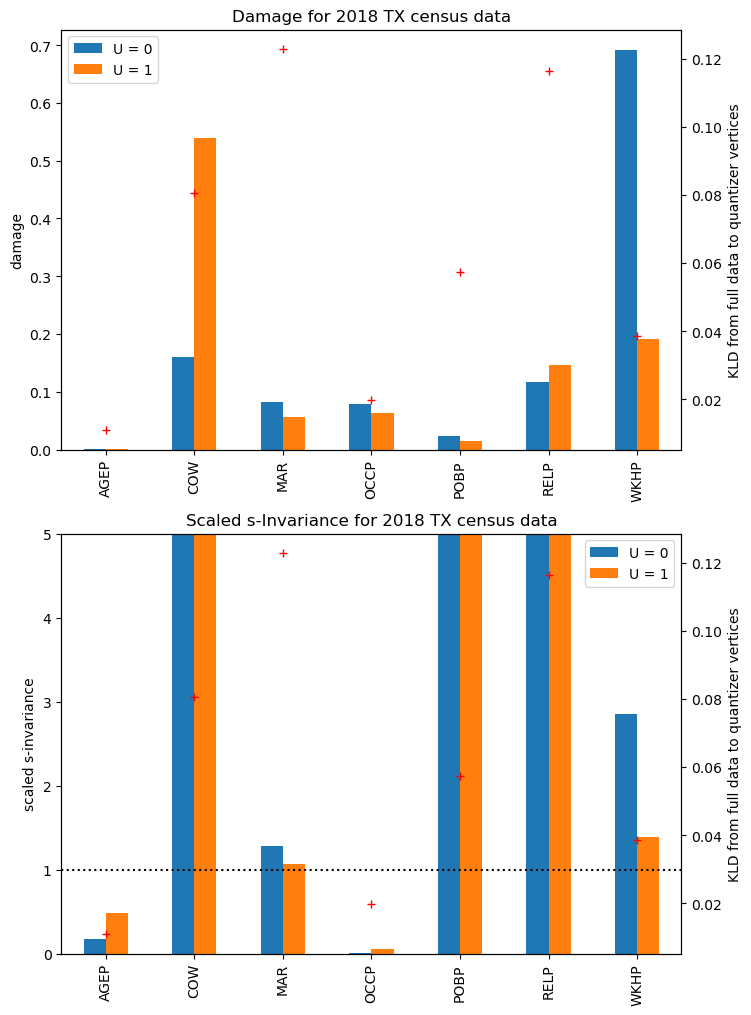

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(8,12))

# Data damage
report.iloc[::2,:2].plot.bar(ax=axs[0])

ax_r = axs[0].twinx()
report.iloc[::2,2].plot(ax=ax_r, style='+', c='red', legend=False)

axs[0].set_xticklabels(report.index.get_level_values(0)[::2])

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, [f'U = {u}' for u in labels]) # Reverses the order

axs[0].set_title(f'Damage for {year} {state} census data')
axs[0].set_ylabel(f'damage')
ax_r.set_ylabel(f'KLD from full data to quantizer vertices')

# s-invariance
report.iloc[1::2,:2].plot.bar(ax=axs[1])

ax_r = axs[1].twinx()
report.iloc[1::2,2].plot(ax=ax_r, style='+', c='red', legend=False)

axs[1].set_xticklabels(report.index.get_level_values(0)[1::2])

axs[1].hlines(y=1, xmin=-1, xmax=7, colors='k', linestyles='dotted')

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, [f'U = {u}' for u in labels]) # Reverses the order

axs[1].set_title(f'Scaled s-Invariance for {year} {state} census data')
axs[1].set_ylabel(f'scaled s-invariance')
ax_r.set_ylabel(f'KLD from full data to quantizer vertices')

axs[1].set_ylim((0,5))

fig.savefig(f'results/initial_forgetting_tests/{year}-{state}-no_forgetting-{epsilon}-{v_init}.png', bbox_inches='tight')

In [ ]:
report.to_csv(f'results/initial_forgetting_tests/{year}-{state}-no_forgetting-{epsilon}-{v_init}.csv')

TO DO:
 - ~~Conduct repair based on stopping numbers~~
 - ~~Compile repaired on-sample and off-sample data~~
 - ~~Produce eval report for the compiled data~~
 - ~~PPrint eval report~~
 - ~~Plot results~~
 - Group code into class
 - Test on 2014 - 2023 ACSIncome data
 - Util function to report representation bias 
 - Util function to compare stopping data to data distributions -- test ideal stopping params
 - Test on |U| > 2 -- split by education class??